In [2]:
%env CUDA_VISIBLE_DEVICES="0"
import numpy as np
import cv2
print ("OpenCV Version : %s " % cv2.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['figure.figsize'] = (20.0, 10.0)

# dimensions of our images.
img_width, img_height = 50, 50

PATH = "/home/piotrek/Data/PKLot/PKLot/PUCPR/Sunny/2012-09-13/2012-09-13_16_55_33.jpg"
XML_PATH = "/home/piotrek/Data/PKLot/PKLot/PUCPR/Sunny/2012-09-13/2012-09-13_16_55_33.xml"

#PATH = "/home/piotrek/Data/PKLot/PKLot/UFPR04/Sunny/2012-12-07/2012-12-07_17_12_25.jpg"
#XML_PATH = "/home/piotrek/Data/PKLot/PKLot/UFPR04/Sunny/2012-12-07/2012-12-07_17_12_25.xml"

env: CUDA_VISIBLE_DEVICES="0"
OpenCV Version : 3.1.0 


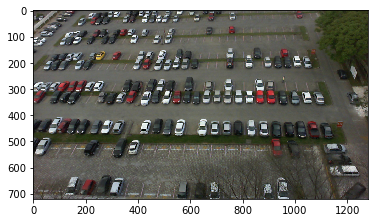

In [4]:
img = cv2.imread(PATH)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [5]:
import xml.etree.ElementTree as ET
from lxml import etree

def get_points(xml_data):
    tree = etree.parse(xml_data)
    root = tree.getroot()
    parking = {"id":[], "occupied":[], "points":[], "rects":[]}
    for elem in root.iter("space"):
        space_points = []
        space_rects = []
        parking["id"].append(int(elem.attrib["id"]))
        try:
            parking["occupied"].append(int(elem.attrib["occupied"]))
        except:
            parking["occupied"].append(None)
            
        points_list = elem.xpath("contour/point")
        for p in points_list:
            space_points.append([int(p.attrib["x"]), int(p.attrib["y"])])
        parking["points"].append(space_points)
        
        rotatedRect = elem.xpath("rotatedRect")[0]
        for r in rotatedRect:
            if r.tag == "angle":
                space_rects.append(int(r.attrib["d"]))
            else:
                space_rects.append(tuple([int(e) for e in r.attrib.values()]))
        parking["rects"].append(tuple(space_rects))

    # check lengths
    assert len(parking["id"]) == len(parking["occupied"]) == len(parking["points"]) == len(parking["rects"])
    return parking

parking = get_points(XML_PATH)

print([item[0] for item in parking.values()])
#print(parking["points"][0])

[1, 0, [[278, 230], [290, 186], [324, 185], [308, 230]], ((300, 207), (55, 32), -74)]


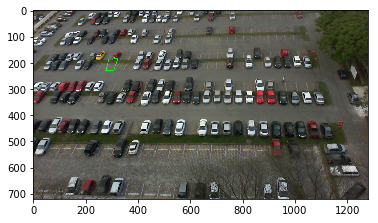

In [6]:
pts = np.array(parking["points"][0], np.int32)
cv2.polylines(img,[pts],True,(0,255,0),thickness=2)
plt.imshow(img)

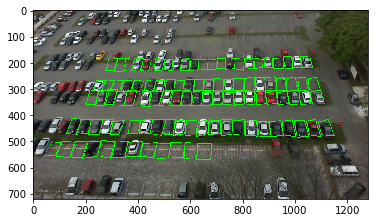

In [7]:
img = cv2.imread(PATH)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
cv2.drawContours(img,np.array(parking["points"],np.int32),-1,(0,255,0),2)
plt.imshow(img)

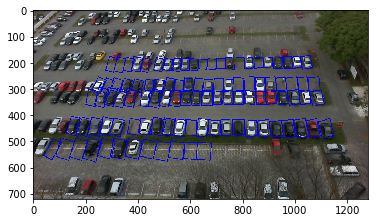

In [8]:
img = cv2.imread(PATH)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
box = [cv2.boxPoints(e) for e in parking["rects"]]
box = np.int0(box)
cv2.drawContours(img,box,-1,(0,0,255),2)
plt.imshow(img)

(56, 32, 3)


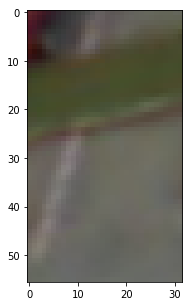

In [9]:
import cv2

def rotate_crop_image(mat, rect):
    (x, y) = rect[0]
    (w, h) = rect[1]
    angle = rect[2]
    w = int(w/2)
    h = int(h/2)
    if angle < -45:
        angle += 90
        w, h = h, w

    height, width = mat.shape[:2]
    image_center = (x, y)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (width, height))
    
    croppes_mat = rotated_mat[y-h: y + h, x-w: x + w]
    return np.array(croppes_mat)

plt.rcParams['figure.figsize'] = (10.0, 5.0)
img = cv2.imread(PATH)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = rotate_crop_image(img, parking["rects"][1])
print(img.shape)
plt.imshow(img)

In [10]:
img = cv2.imread(PATH)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
car_list = np.empty((0,img_width, img_height,3), 'uint8')

for rect in parking["rects"]:
    car_list = np.append(car_list, [cv2.resize(rotate_crop_image(img, rect), (img_width, img_height))], axis=0)

print(car_list.shape)

(100, 50, 50, 3)


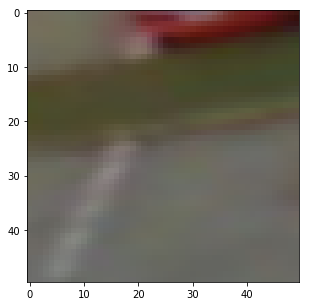

In [11]:

plt.imshow(car_list[0])

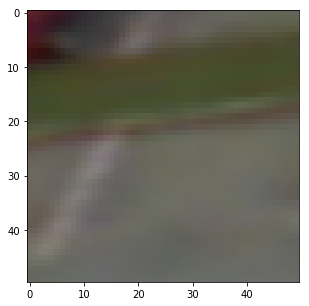

In [12]:
plt.imshow([cv2.resize(rotate_crop_image(img, parking["rects"][1]), (img_width, img_height))][0])

In [13]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator


model = load_model('weights.hdf5')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 22, 22, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          18496     
__________

In [14]:
test_datagen = ImageDataGenerator(
        samplewise_center=True,
        rescale=1./255
)

test_generator = test_datagen.flow(car_list, shuffle=False)

In [15]:
predictions = model.predict_generator(test_generator, steps = car_list.shape[0]/32)
predictions = (predictions > 0.5).astype('int32').flatten()

In [16]:
predictions

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0], dtype=int32)

In [17]:
np.array(parking['occupied'])

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0])

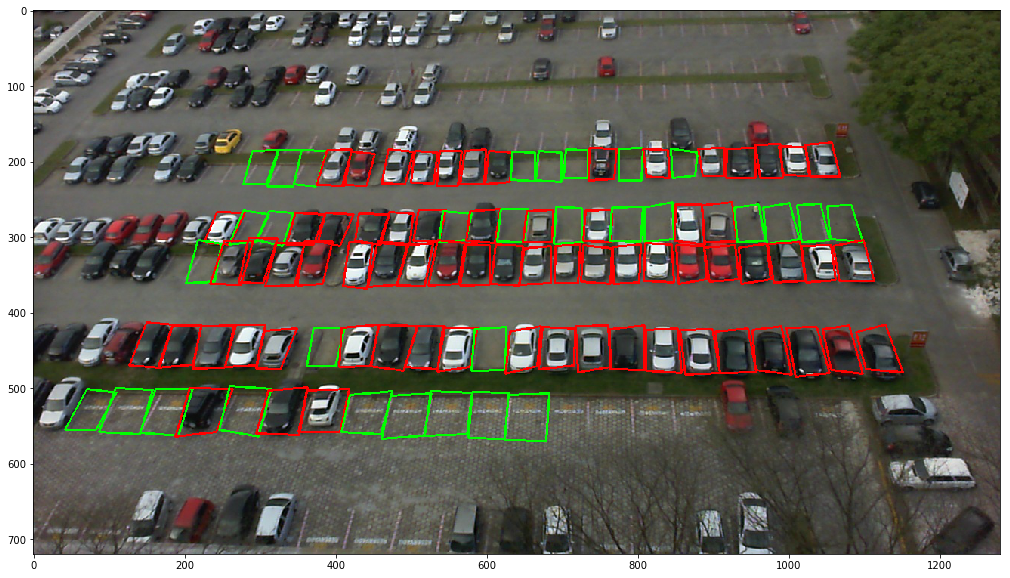

In [18]:
img = cv2.imread(PATH)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
for i, e in enumerate(parking["points"]):
    pts = np.array(e, np.int32)
    cv2.polylines(img,[pts],True,(int((predictions[i])*255),int((1-predictions[i])*255),0),thickness=2)
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.imshow(img)

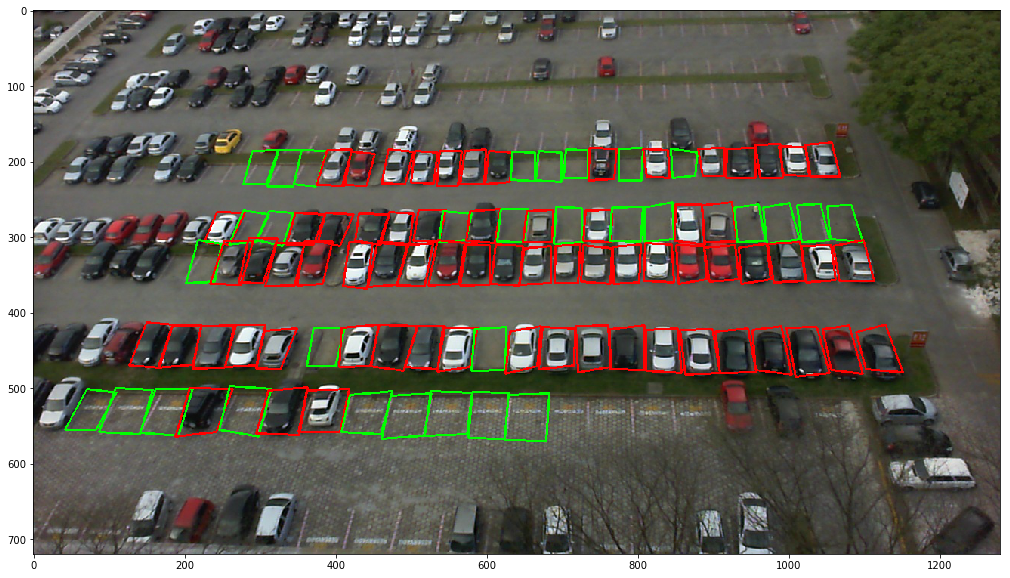

In [19]:
img = cv2.imread(PATH)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
for i, e in enumerate(parking["points"]):
    pts = np.array(e, np.int32)
    cv2.polylines(img,[pts],True,(int((parking['occupied'][i])*255),int((1-parking['occupied'][i])*255),0),thickness=2)
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.imshow(img)